## 1. Prezentare generala a aplicatiei

Aceasta aplicatie simuleaza modul de functionare al unui scaner de Tomografie Computerizata (CT) din perspectiva procesului de achizitie a datelor si a reconstructiei imaginilor. In realitate, un scaner CT nu captureaza un obiect in ansamblu dintr-o singura masuratoare, ci il scaneaza **strat cu strat**. Pentru fiecare pozitie, sistemul emite raze X din mai multe unghiuri, masoara raspunsul obtinut si apoi deplaseaza mecanic ansamblul pentru a scana urmatorul strat.

Fiecare astfel de strat reprezinta o sectiune transversala a obiectului. Un scan complet presupune repetarea acestui proces de foarte multe ori, iar rezultatul final este un volum tridimensional obtinut prin suprapunerea tuturor straturilor reconstruite individual.

Aplicatia de fata se concentreaza pe **un singur strat** al acestui proces. Alegerea unui layer unic permite observarea clara a mecanismului de reconstructie, fara a introduce complexitatea suplimentara a gestionarii intregului volum 3D. In practica, un scaner CT real ar aplica exact aceeasi procedura pentru fiecare strat, salvand rezultatele succesiv, pana la obtinerea intregului obiect scanat.

Astfel, aplicatia reproduce fluxul de lucru al unui sistem CT real, dar izolat la nivelul unei singure sectiuni, ceea ce o face usor de analizat, inteles si extins ulterior pentru reconstructii volumetrice complete.

## 2. Fluxul aplicatiei

Aplicatia primeste ca intrare date obtinute in urma unui proces de scanare CT pentru un anumit obiect, corespunzatoare unei singure sectiuni. Aceste date contin informatii masurate din mai multe unghiuri, rezultate din traversarea obiectului de catre raze X.

Pe baza acestor masuratori, aplicatia realizeaza reconstructia sectiunii scanate si obtine o imagine care reprezinta structura interna a obiectului la nivelul acelui strat. Rezultatul final este o imagine bidimensionala care poate fi analizata vizual si comparata cu o referinta, atunci cand aceasta este disponibila.

Procesul complet urmeaza urmatoarele etape principale:
- incarcarea sau generarea (prin inversarea procesarii unei imagini CT) datelor de scanare;
- reconstructia imaginii corespunzatoare sectiunii analizate;
- evaluarea si vizualizarea rezultatului obtinut.

### Librarii utilizate

- **NumPy** este utilizata pentru operatii numerice si lucrul cu structuri de tip matrice.
- **SciPy** este folosita pentru incarcarea datelor experimentale si pentru unele operatii numerice avansate.
- **Matplotlib** permite afisarea imaginilor si a rezultatelor obtinute intr-o forma vizuala clara.
- **scikit-image** este folosita pentru operatii specifice procesarii imaginilor, inclusiv simularea procesului de scanare si reconstructia imaginilor.
- **Nibabel** permite citirea fisierelor medicale in format NIfTI, utilizate frecvent in imagistica CT.
- **DagsHubFilesystem** este utilizata pentru accesarea la distanta a seturilor de date, fara a fi necesara descarcarea completa a acestora in prealabil.
- **Joblib** si **tqdm** sunt folosite pentru accelerarea si monitorizarea executiei operatiilor costisitoare din punct de vedere computațional.
- **Alte module standard** (os, time, random, math) sunt utilizate pentru gestionarea fisierelor, masurarea timpilor de executie si operatii auxiliare.

In [1]:
import os
import time
import random
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from math import ceil
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr, svds
from dagshub.streaming import DagsHubFilesystem
from skimage.transform import resize, radon, iradon
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

## 3. Achizitia datelor pentru demo

Pentru a putea demonstra functionalitatea aplicatiei, este necesara utilizarea unor date de scanare CT. In mod ideal, aceste date ar trebui sa fie reale, deoarece ele reflecta fidel conditiile si limitarile unui sistem CT din practica. Totusi, datele brute de scanare, sub forma de sinograme, sunt rareori disponibile public, deoarece scanerele CT comerciale efectueaza de obicei o mare parte din procesare direct in interiorul echipamentului, iar aceste date nu sunt expuse utilizatorului final.

Din acest motiv, aplicatia foloseste doua abordari complementare pentru achizitia datelor necesare demonstratiei.

Prima abordare consta in generarea artificiala a sinogramelor prin simularea procesului de scanare, pornind de la o imagine cunoscuta a unei sectiuni. Aceasta imagine de referinta poarta numele de *phantom* si reprezinta structura interna a unui obiect, folosita ca etalon pentru evaluarea calitatii reconstructiei. Prin aceasta metoda, procesul de reconstructie este inversat: in loc sa pornim de la masuratori reale, generam datele de scanare si apoi incercam sa reconstruim imaginea initiala. Aceasta abordare permite observarea clara a modului in care rezolutia imaginii si numarul de unghiuri de scanare influenteaza calitatea rezultatului final, prin comparatie directa cu imaginea de referinta.

A doua abordare utilizeaza date provenite din scanari reale, pentru a demonstra ca aplicatia functioneaza si in conditii apropiate de cele din practica. Aceste date contin masuratori experimentale reale si introduc imperfectiuni specifice procesului de achizitie, precum zgomotul si erorile de masurare. Utilizarea acestui tip de date valideaza aplicatia dincolo de scenarii ideale si confirma aplicabilitatea metodei in contexte reale.

### 3.1 Achizitia datelor din InLab COVID-19 Images Dataset

Pentru demonstratia aplicatiei a fost utilizat *InLab COVID-19 Images Dataset*, care contine scanari CT reale ale toracelui, provenite din investigatii medicale clinice. Datele sunt anonimizate, astfel incat nu contin informatii care pot identifica persoanele scanate. Acest set de date este pus la dispozitie public si permite utilizarea in contexte academice si educationale.

#### Accesarea setului de date

Aplicatia foloseste API-ul DagsHub pentru a monta setul de date ca un sistem de fisiere virtual. Astfel, fisierele pot fi accesate si citite direct din repo-ul online, fara a fi nevoie sa fie descarcat local integral.

In [2]:
# Initialize DagsHub Filesystem for remote data streaming
fs = DagsHubFilesystem(".", repo_url="https://dagshub.com/DagsHub-Datasets/inlab-covid-19-images-dataset-dataset")
print("Remote filesystem mounted.")

Accessing as mihaipriboi

Remote filesystem mounted.


#### Citirea unei sectiuni CT din setul de date

Aceasta functie preia o sectiune aleatoare dintr-un volum CT disponibil in setul de date. Se foloseste API-ul DagsHub pentru a accesa fisierele, iar daca fisierul selectat nu exista local, acesta este descarcat si salvat in cache. 

Ulterior, volumul CT este incarcat, se extrage sectiunea axiala intermediara, se normalizeaza valorile pixelilor intre 0 si 1 si se redimensioneaza la rezolutia dorita. Rezultatul este o matrice 2D ce reprezinta imaginea de referinta utilizata pentru reconstructie.

In [3]:
def get_covid_phantom(target_size=256, file_index=None, file_name=None):
  ct_dir = "s3://inlab-opendata-covid-anonymized-images/chest_ct/images"
  cache_dir = "data/ct_cache"
  os.makedirs(cache_dir, exist_ok=True)

  # List remote files and pick one
  ct_files = fs.listdir(ct_dir)

  if file_index is not None and 0 <= file_index < len(ct_files):
    selected_file = ct_files[file_index]
  elif file_name is not None and file_name in ct_files:
    selected_file = file_name
  else:
    selected_file = random.choice(ct_files)

  remote_path = f"{ct_dir}/{selected_file}"
  local_path = os.path.join(cache_dir, selected_file)

  # Download/Cache logic
  if not os.path.exists(local_path):
    print(f"Downloading {selected_file} to cache...")
    with fs.open(remote_path, "rb") as f_remote:
      with open(local_path, "wb") as f_local:
        f_local.write(f_remote.read())
  else:
    print(f"Loading {selected_file} from local cache.")

  # Load NIfTI volume from local file
  img = nib.load(local_path)
  data = img.get_fdata()

  # Extract middle axial slice
  z_mid = data.shape[0] // 2
  slice_img = data[z_mid].T 

  # Normalize to [0, 1] range
  slice_min, slice_max = np.min(slice_img), np.max(slice_img)
  phantom_norm = (slice_img - slice_min) / (slice_max - slice_min)

  # Resize to target resolution (square for simplicity)
  phantom_resized = resize(phantom_norm, (target_size, target_size), anti_aliasing=True)
  
  return phantom_resized

#### Generarea si vizualizarea sinogramei

Functia `generate_sinogram` simuleaza masuratorile obtinute de un scaner CT prin calcularea proiectiilor razelor X pentru un numar specificat de unghiuri, utilizand `skimage.transform.radon`. Rezultatul este sinograma, o matrice care contine intensitatile masurate pentru fiecare detector si unghi.

Functia `display_sinogram` afiseaza sinograma sub forma unei imagini 2D, unde axa orizontala reprezinta unghiurile de proiectie, iar axa verticala pozitia detectorilor. Aceasta vizualizare permite observarea informatiilor colectate de scaner inainte de reconstructia imaginii.

In [4]:
def generate_sinogram(image, num_angles=180):
  # Generate sinogram using Radon transform
  theta = np.linspace(0., 180., num_angles, endpoint=False)
  sinogram = radon(image, theta=theta, circle=False)
  return sinogram, theta

def display_sinogram(sinogram, theta):
  plt.figure(figsize=(8, 6))
  plt.imshow(sinogram, cmap='gray', aspect='auto',
             extent=(theta[0], theta[-1], 0, sinogram.shape[0]))
  plt.title('Sinogram (Radon Transform Space)')
  plt.xlabel('Projection Angle (Degrees)')
  plt.ylabel('Detector Position (Pixels)')
  plt.colorbar(label='Attenuation Intensity')
  plt.show()

## 3.2 Achizitia datelor din setul Walnut CT

Pentru a demonstra functionarea aplicatiei pe date reale si independente de cele simulate, am folosit *Tomographic X‑ray data of a walnut*, un set de date deschis care contine masuratori experimentale efectuate pe o sectiune reala a unuei nuci. Acest set de date include sinograme obtinute prin scanare X‑ray si o reconstructie de referinta (ground truth) calculata cu o metoda de filtrare profesionala.

Datele provin din masuratori fizice efectuate pe un obiect real, fara procesare simulata, folosind un echipament CT de laborator. In cadrul setului de date exista variante cu rezolutii diferite ale sinogramelor si o reconstructie de referinta de inalta calitate obtinuta dintr‑un numar mare de proiectii.

Acest dataset este licentiat sub o licenta deschisa *CC BY 4.0*, ceea ce permite reutilizarea in scopuri de cercetare si educationale.

Utilizarea acestui set de date valideaza aplicatia pe cazuri reale si ofera un punct de comparatie pentru performanta reconstructiilor realizate cu algoritmi proprii, atat din punct de vedere vizual, cat si numeric.

#### Codul de incarcare a sinogramei

In [5]:
def load_walnut_data(data_dir="walnut", file_name="Data328.mat"):
  # Loads real-world experimental data from the Walnut dataset.
  mat_path = os.path.join(data_dir, file_name)
  gt_path = os.path.join(data_dir, "GroundTruthReconstruction.mat")
  
  if not os.path.exists(mat_path):
    print(f"Warning: {mat_path} not found.")
    return None, None
      
  sinogram = scipy.io.loadmat(mat_path)['m']
  ground_truth = None
  
  if os.path.exists(gt_path):
    ground_truth = scipy.io.loadmat(gt_path)['FBP1200']
      
  return sinogram, ground_truth

# 4. Algoritmi de reconstructie a imaginii

Aceasta sectiune prezinta metodele utilizate pentru reconstruirea unei imagini din datele colectate in sinograma. Indiferent de algoritmul specific, scopul comun este de a determina distributia intensitatilor in planul scanat pornind de la masuratorile unghiulare ale razelor X.

Conceptual, toate metodele se bazeaza pe rezolvarea unui **sistem de ecuatii liniare** de forma:

$$
A x = b
$$

unde:

* $b$ reprezinta vectorul masuratorilor (sinograma),
* $x$ reprezinta vectorul necunoscutelor – intensitatile punctelor din planul scanat,
* $A$ este matricea sistemului, care modeleaza modul in care fiecare pixel contribuie la fiecare masuratoare (echivalent cu transformarea Radon discretizata).

Diferitele metode de reconstructie difera in modul in care abordeaza rezolvarea acestui sistem:

* unele folosesc formule analitice pentru a aproxima solutia,
* altele aplica tehnici de minimizare a erorii patratice (least squares) pentru a obtine cea mai buna aproximatie a vectorului $x$,
* in unele cazuri, se utilizeaza factorizari speciale (SVD, Cholesky) pentru stabilitate numerica si eficienta.

Indiferent de abordare, toate metodele urmaresc doua obiective principale: **acuratetea reconstructiei**, respectiv cat de apropiata este imaginea reconstruita de datele originale, si **robustetea numerica**, astfel incat solutia sa fie stabila chiar si in prezenta unui numar limitat de proiectii sau a zgomotului in masuratori.

#### Transformarea Radon

Transformarea Radon este operatorul matematic care sta la baza masuratorilor unui scaner CT. Pentru o imagine bidimensionala $f(x,y)$, transformata Radon calculeaza suma intensitatilor de-a lungul unei linii dreptunghiulare corespunzatoare fiecarui unghi de proiectie $\theta$. 

Practic, pentru un unghi fix $\theta$, fiecare element din sinograma reprezinta **cat de mult semnal a traversat obiectul** pe directia respectiva. Repetand aceasta operatie pentru un set de unghiuri, obtinem sinograma completa, care contine informatii suficiente pentru reconstructia imaginii originale. 

Transformarea Radon poate fi privita ca echivalentul discret al "fotografiilor de umbre" luate din diferite directii. Fiecare proiectie ofera o masuratoare integrata, iar combinarea lor permite reconstruirea distributiei interne a obiectului.

## 4.0 Construirea matricei sistemului

Functia `build_system_matrix` construieste **matricea sistemului $A$**, care reprezinta modul in care fiecare pixel contribuie la masuratorile sinogramei.

Ideile principale:

* Fiecare coloana a matricei corespunde unui **pixel individual** din imaginea reconstruita.
* Pentru fiecare pixel, calculam proiectia sa folosind transformata Radon, pentru toate unghiurile specificate. Aceasta ne spune cat contribuie pixelul la fiecare masuratoare a detectorilor.
* Rezultatul este o matrice cu **numarul de masuratori pe randuri** si **numarul de pixeli pe coloane**.
* Calculul este paralelizat pentru a accelera procesul, deoarece pentru imagini de dimensiuni mari numarul de coloane poate fi foarte mare.

Folosind matricea $A$: fiecare masuratoare din sinograma poate fi aproximata ca o combinatie liniara a intensitatilor pixelilor, conform acestei matrice.

In [6]:
def build_system_matrix(n, theta):
  num_pixels = n * n
  # Determine the size of a single projection to know the number of rows in A
  dummy_img = np.zeros((n, n))
  sample_projection = radon(dummy_img, theta=theta, circle=False)
  m = sample_projection.size
  
  print(f"Constructing A matrix ({m}x{num_pixels}) using Parallel CPU...")
  
  def get_column(i):
    basis_img = np.zeros(num_pixels, dtype=np.float32)
    basis_img[i] = 1.0
    # Reshape to 2D and apply Radon transform
    proj = radon(basis_img.reshape((n, n)), theta=theta, circle=False)
    return proj.flatten()

  # Parallel processing to speed up the Radon transform for each pixel
  columns = Parallel(n_jobs=-1)(
    delayed(get_column)(i) for i in tqdm(range(num_pixels), desc="Building A")
  )
  
  # Stack columns to form the matrix A
  A = np.column_stack(columns)
  return A

## 4.1 Metoda Analitica (FBP)

Metoda Analitica, cunoscuta si sub numele de **Filtered Back Projection (FBP)**, este metoda de referinta pentru reconstructia imaginilor din sinograme.  

Caracteristici principale:

* Functioneaza ca un **black box**: primeste sinograma si un set de unghiuri, si returneaza imaginea reconstruita fara a necesita construirea explicita a matricei sistemului.  
* Este metoda standard in tomografie, utilizata pe scară larga in scanerele CT reale.  
* Ofera rezultate rapide si stabile, fiind utila pentru comparatie cu metodele numerice bazate pe sisteme liniare.  

Aceasta metoda serveste astfel ca etalon, permitand evaluarea calitatii si acuratetii celorlalte metode implementate in aplicatie.

## 4.2 CMMP folosind `numpy.linalg.lstsq`

Aceasta metoda rezolva problema de **minimizare a erorii patratice** gasind vectorul $x$ care minimizeaza eroarea patrata:

$$
\min_x \|A x - b\|_2
$$

utilizand direct functia `numpy.linalg.lstsq`.  

### Principiu matematic

* Functia `lstsq` gaseste solutia vectorului $x$ care minimizeaza norma L2 a reziduului $r = A x - b$.  
* Este echivalent cu rezolvarea sistemului normal, dar intern biblioteca NumPy gestioneaza stabilitatea numerica si regularizarea.  
* Optional, se poate specifica un prag `rcond` pentru ignorarea valorilor singulare foarte mici, prevenind instabilitati.

### Avantaje

* Simplu de folosit, fara implementari manuale de factorizare.  
* Stabil numeric pentru matrici mari si rareori patrate.  
* Servește ca o metoda de comparatie directa cu SVD si Cholesky, fiind rapidă și robustă.


## 4.3 CMMP folosind DVS

Metoda **CMMP prin descompunerea in valori singulare (DVS)**, similar, gaseste vectorul $x$ pentru $\min_x \|A x - b\|_2$.

### Principiu matematic

#### 1. Descompunem matricea $A$ utilizand SVD:

$$
A = U \, S \, V^T
$$

unde:

* $U \in \mathbb{R}^{m \times m}$ este matrice ortogonala, continand vectorii proprii ai lui $A A^T$,  
* $S \in \mathbb{R}^{m \times n}$ este matrice diagonala cu valorile singulare pozitive $\sigma_i$,  
* $V \in \mathbb{R}^{n \times n}$ este matrice ortogonala, continand vectorii proprii ai lui $A^T A$.

#### 2. Solutia CMMP se exprima ca:

$$
x = V \, S^{-1} \, U^T b
$$

unde $S^{-1}$ este inversa valorilor singulare nenule. Pentru valori singulare foarte mici, folosim un prag (`tol`) pentru a evita instabilitatile numerice.

#### 3. Implementarea in cod:

* Se calculeaza DVS folosind `np.linalg.svd(A, full_matrices=False)`.  
* Se inverseaza valorile singulare mai mari decat pragul `tol`.  
* Rezultatul final este obtinut prin inmultirea matricilor conform formulei de mai sus.

### Avantaje

* Stabil numeric chiar si pentru matrici aproape singulare.  
* Permite controlul pragului de inversare pentru regularizare.  
* Este metoda principala atunci cand matricea sistemului $A$ este mare si rar populata.


In [7]:
def solve_lstsq_svd(A, b, rcond=None):
  m, n = A.shape

  U, s, Vt = np.linalg.svd(A, full_matrices=False)

  if rcond is None:
    rcond = max(m, n) * np.finfo(float).eps

  tol = rcond * s[0]

  s_inv = np.zeros_like(s)
  for i in range(len(s)):
    if s[i] > tol:
      s_inv[i] = 1.0 / s[i]

  x = Vt.T @ (s_inv * (U.T @ b))
  return x

## 4.4 CMMP folosind Cholesky

Aceasta metoda rezolva sistemul $A x = b$ prin **factorizarea sistemului normal**:

$$
A^T A \, x = A^T b
$$

cu posibila regularizare Tikhonov (adaugarea termenului $\lambda I$ pentru stabilitate):

$$
(A^T A + \lambda I) x = A^T b
$$

### Principiu matematic

#### 1. Construim **sistemul normal** $A^T A + \lambda I$ si vectorul $A^T b$.  
#### 2. Aplicam factorizarea **Cholesky**: pentru o matrice simetrica pozitiv definita $M$, se gaseste $L$ astfel incat

$$
M = L L^T
$$

unde:
* $L$ este o matrice triunghiulara inferioara.

#### 3. Rezolvarea sistemului se face in doi pasi:

* **Forward substitution**: rezolvam $L y = A^T b$ pentru $y$,
* **Backward substitution**: rezolvam $L^T x = y$ pentru $x$.

Aceasta abordare evita inversarea directa a matricii si este mai stabila numeric decat formula explicita a sistemului normal.

### Implementare

* `cholesky_low_level` construieste manual matricea $L$, implementand formula $A = L L^T$.
* `solve_cholesky` rezolva sistemul in doi pasi, utilizand substitutii directe.
* In practica, pentru matrici mari se foloseste `np.linalg.cholesky`, dar logica ramane aceeasi.
* Valorile negative din solutie sunt eliminate, deoarece intensitatile pixelilor nu pot fi negative.

Aceasta metoda ofera un echilibru intre **precizie**, **stabilitate numerica** si **eficienta computationale**, fiind utila atunci cand matricea sistemului este simetrica pozitiv definita si relativ densa.


In [8]:
def cholesky_low_level(A):
  # A = L * L.T
  n = A.shape[0]
  L = np.zeros_like(A)

  for i in range(n):
    for j in range(i + 1):
      s = np.dot(L[i, :j], L[j, :j])
      if i == j:
        L[i, j] = np.sqrt(max(A[i, i] - s, 1e-12))
      else:
        L[i, j] = (1.0 / L[j, j]) * (A[i, j] - s)
  return L

def solve_cholesky(L, b):
  # Forward substitution (L * y = b)
  n = L.shape[0]
  y = np.zeros(n)
  for i in range(n):
    y[i] = (b[i] - np.dot(L[i, :i], y[:i])) / L[i, i]

  # Backward substitution (L.T * x = y)
  x = np.zeros(n)
  Lt = L.T
  for i in range(n - 1, -1, -1):
    x[i] = (y[i] - np.dot(Lt[i, i + 1:], x[i + 1:])) / Lt[i, i]
  return x

## 4.5 Functia `reconstruct_image`

Functia `reconstruct_image` unifica toate metodele de reconstructie intr-un **singur punct de apel**, oferind o interfata comuna.

### Functionare generala

1. **Inputuri**:
   * `sinogram` – masuratorile obtinute din scanare,
   * `theta` – unghiurile proiectiilor,
   * `method` – metoda de reconstructie (`FBP`, `LSTSQ`, `SVD`, `CHOLESKY`),
   * `kwargs` – parametri optionali, cum ar fi matricea sistemului `A`, dimensiunea imaginii `n`, sau parametrul de regularizare `lambd`.

2. **Preprocesare**:
   Sinograma este transformata in vector pentru metodele bazate pe sisteme liniare (`LSTSQ`, `SVD`, `CHOLESKY`), iar parametrii optionali sunt setati la valori implicite daca nu sunt furnizati.

3. **Selectarea metodei**:
   * `FBP` – se aplica metoda analitica Filtered Back Projection, returnand imaginea direct din sinograma,
   * `LSTSQ` – rezolva problema CMMP folosind `numpy.linalg.lstsq`,
   * `SVD` – rezolva problema CMMP folosind descompunerea in valori singulare (DVS),
   * `CHOLESKY` – rezolva problema CMMP prin construirea sistemului normal si factorizarea Cholesky.

4. **Postprocesare**:
   * Pentru metodele liniare, vectorul rezultat este transformat intr-o matrice 2D corespunzatoare dimensiunii imaginii,

Aceasta functie simplifica testarea si compararea metodelor, permitand schimbarea algoritmului de reconstructie printr-un singur argument, fara a modifica restul fluxului de lucru.


In [9]:
def reconstruct_image(sinogram, theta, method='FBP', **kwargs):
  output_size = kwargs.get('output_size', None)
  circle = kwargs.get('circle', False)

  b = sinogram.flatten()
  A = kwargs.get('A', None)
  n = kwargs.get('n', 64)
  lambd = kwargs.get('lambd', None) # Regularization parameter

  # 1. Analytic Method
  if method == 'FBP':
    return iradon(sinogram, theta=theta, circle=circle, output_size=output_size)

  # 2. Least Squares (CMMP) using numpy.linalg.lstsq
  if method == 'LSTSQ':
    if A is None: raise ValueError("Matrix A is required for LSTSQ.")
    # Solves min ||Ax - b||_2
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=lambd)
    return x.reshape((n, n))

  # 3. Least Squares using SVD
  if method == 'SVD':
    if A is None: raise ValueError("Matrix A is required for SVD.")
    x = solve_lstsq_svd(A, b, rcond=lambd)
    return x.reshape((n, n))
  
  # 4. Least Squares using Cholesky Decomposition
  if method == 'CHOLESKY':
    if A is None: raise ValueError("Matrix A is required for Cholesky.")
    if lambd is None: lambd = 1e-2

    # (A.T @ A + lambda * I)
    print("Building Normal Equations...")
    n_cols = A.shape[1]
    ATA = A.T @ A + lambd * np.eye(n_cols)
    ATb = A.T @ b
    
    # In python, Cholesky low-level is very slow for large matrices
    # So we use the optimized NumPy variant for factorization, but the logic remains the same
    print("Factorizing...")
    L = np.linalg.cholesky(ATA)
    
    print("Solving...")
    x = solve_cholesky(L, ATb)
    
    x[x < 0] = 0
    return x.reshape((n, n))

  return None

#### Compararea imaginilor

Functia `plot_comparison` permite evaluarea vizuala si numerica a calitatii reconstructiei in raport cu imaginea de referinta (*phantom*).

* **Vizual**: afiseaza imaginea originala si imaginea reconstruita alaturat, dupa redimensionare si normalizare pentru comparatie corecta.
* **Numeric**: calculeaza trei metrici de acuratete:
  - **Mean Squared Error (MSE):** eroarea patrata medie intre imagini,
  - **Peak Signal-to-Noise Ratio (PSNR):** raportul semnal-zgomot, exprimat in decibeli,
  - **Structural Similarity Index (SSIM):** masura a similitudinii perceptuale intre imagini.

Aceasta combinatie de evaluari permite atat observarea directa a diferentei dintre imagini, cat si cuantificarea precisa a calitatii reconstructiei.

In [10]:
def plot_comparison(reconstruction, phantom):
  # Resize/Normalize for fair metric calculation
  if reconstruction.shape != phantom.shape:
    reconstruction = resize(reconstruction, phantom.shape, anti_aliasing=True)

  # Rescale to [0,1]
  recon_norm = (reconstruction - np.min(reconstruction)) / (np.max(reconstruction) - np.min(reconstruction))
  phantom_norm = (phantom - np.min(phantom)) / (np.max(phantom) - np.min(phantom))

  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  axes[0].imshow(phantom_norm, cmap='gray')
  axes[0].set_title('Original Phantom (Ground Truth)')
  axes[0].axis('off')

  axes[1].imshow(recon_norm, cmap='gray')
  axes[1].set_title('Reconstructed Image ($x$)')
  axes[1].axis('off')
  plt.show()

  # Compute Numerical Accuracy
  mse = mean_squared_error(phantom_norm, recon_norm)
  psnr = peak_signal_noise_ratio(phantom_norm, recon_norm, data_range=1)
  ssim = structural_similarity(phantom_norm, recon_norm, data_range=1)

  print(f" Reconstruction Quality Metrics:")
  print(f"Mean Squared Error (MSE): {mse:.6f}")
  print(f"PSNR: {psnr:.2f} dB")
  print(f"SSIM: {ssim:.4f}")

#### Compararea reconstructiilor manuale

Functia `plot_comparison_numpy` este similara cu `plot_comparison`, dar este adaptata pentru metodele **manuale** bazate pe rezolvarea sistemului $A x = b$ (LSTSQ, SVD, Cholesky).  

Caracteristici principale:

* Poate afisa mai multe reconstructii alaturat, fiecare obtinuta cu un numar diferit de unghiuri de proiectie.
* Normalizeaza atat imaginea de referinta (*phantom*), cat si reconstructiile pentru o comparatie corecta.
* Converteste vectorii 1D in matrice 2D daca este necesar si redimensioneaza imaginile la dimensiunea phantomului.
* Afiseaza metrici numerice pentru fiecare reconstructie: **MSE**, **PSNR** si **SSIM**, impreuna cu numarul de unghiuri folosite.

Aceasta functie permite comparatii vizuale si cantitative multiple, facilitand evaluarea performantelor diferitelor metode manuale de reconstructie.

In [11]:
def plot_comparison_numpy(reconstructions, phantom, num_angles, rows=1):
  if reconstructions is None or len(reconstructions) == 0:
    print("Error: No reconstructions provided.")
    return

  # Ensure list-like input
  if not isinstance(reconstructions, (list, tuple)): reconstructions = [reconstructions]
  if not isinstance(num_angles, (list, tuple)): num_angles = [num_angles] * len(reconstructions)

  # Normalization helper
  def normalize(img):
    denom = np.max(img) - np.min(img)
    if denom == 0:
      return np.zeros_like(img)
    return (img - np.min(img)) / denom

  phantom_norm = normalize(phantom)

  total_plots = len(reconstructions) + 1
  cols = ceil(total_plots / rows)

  fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
  axes = np.atleast_1d(axes).flatten()

  axes[0].imshow(phantom_norm, cmap='gray')
  axes[0].set_title("Phantom (Ground Truth)")
  axes[0].axis('off')

  for i, reconstruction in enumerate(reconstructions, start=1):
    if reconstruction is None:
      axes[i].set_title("Reconstruction failed")
      axes[i].axis('off')
      continue

    # Handle flat vectors
    if reconstruction.ndim == 1:
      n = int(np.sqrt(reconstruction.size))
      reconstruction = reconstruction.reshape((n, n))

    # Resize if needed
    if reconstruction.shape != phantom.shape:
      reconstruction = resize(reconstruction, phantom.shape, anti_aliasing=True)

    recon_norm = normalize(reconstruction)

    # Metrics
    mse = mean_squared_error(phantom_norm, recon_norm)
    psnr = peak_signal_noise_ratio(phantom_norm, recon_norm, data_range=1)
    ssim = structural_similarity(phantom_norm, recon_norm, data_range=1)

    axes[i].imshow(recon_norm, cmap='gray')
    axes[i].set_title(f"Angles: {num_angles[i-1]}\n" f"MSE: {mse:.4e}\n" f"PSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}")
    axes[i].axis('off')

  for j in range(total_plots, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.show()

# 5. Testarea aplicatiei

#### Setul de date **InLab COVID-19 Images Dataset**

Se preia o sectiune CT aleatoare sau specificata din setul de date COVID-19, care va servi ca *phantom* pentru testare. Aceasta imagine va fi considerata referinta pentru evaluarea reconstructiilor.

Se simuleaza masuratorile unui scaner CT aplicand transformata Radon pe *phantom*.

Loading b0b8648da0acceb3b7326a206c25ea9f.nii from local cache.


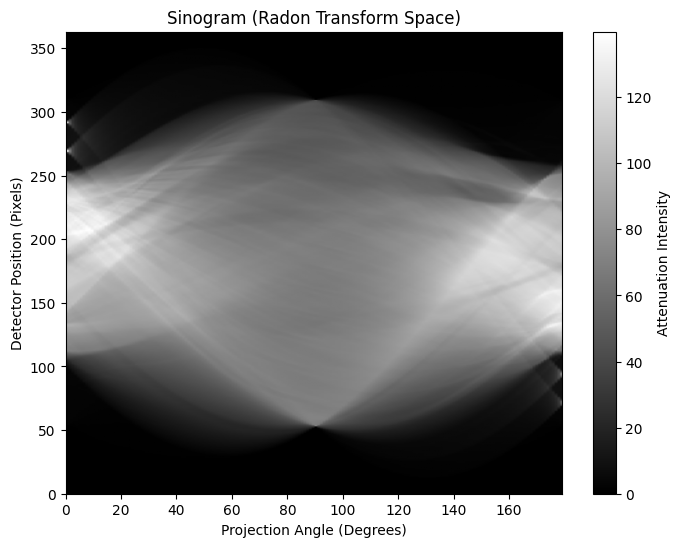

In [12]:
# Load Data
target_phantom = get_covid_phantom(target_size=256, file_name="b0b8648da0acceb3b7326a206c25ea9f.nii")

# Generate Sinogram (b)
sinogram, theta = generate_sinogram(target_phantom, num_angles=180)
display_sinogram(sinogram, theta)

Se reconstruieste imaginea din sinograma folosind metoda analitica FBP și se compara vizual cu imaginea originală.

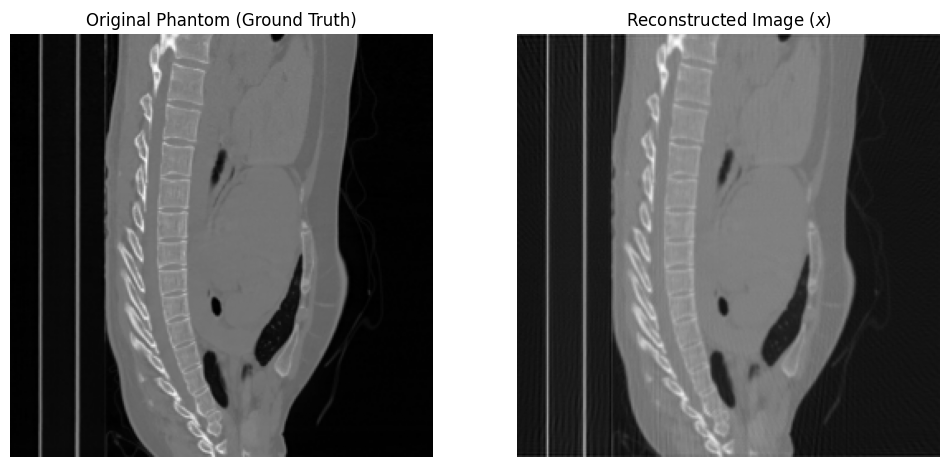

 Reconstruction Quality Metrics:
Mean Squared Error (MSE): 0.003465
PSNR: 24.60 dB
SSIM: 0.7271


In [13]:
recon = reconstruct_image(sinogram, theta, method="FBP")
plot_comparison(recon, target_phantom)

Se testează metodele algebrice (LSTSQ, SVD, Cholesky) pe o versiune redimensionată a phantomului, folosind diferite numere de unghiuri, și se măsoară timpul de execuție pentru fiecare metodă.

In [14]:
# Configuration
low_res = 64

phantom_small = resize(target_phantom, (low_res, low_res))

num_angles = [5, 10, 20, 60]

reconstructions = []
reconstructions_svd = []
reconstructions_cholesky = []

for i in range(len(num_angles)):
  angles = num_angles[i]
  print(f"\nReconstruction with {angles} Projection Angles")
  # Prepare Data
  sinogram_small, theta_small = generate_sinogram(phantom_small, num_angles=angles)

  # Build Matrix A for the Algebraic Methods
  A = build_system_matrix(low_res, theta_small)

  start = time.time()
  reconstructions.append(reconstruct_image(sinogram_small, theta_small, method="LSTSQ", A=A, n=low_res))
  lstsq_time = time.time() - start

  start = time.time()
  reconstructions_svd.append(reconstruct_image(sinogram_small, theta_small, method="SVD", A=A, n=low_res, lambd=1e-2))
  svd_time = time.time() - start

  start = time.time()
  reconstructions_cholesky.append(reconstruct_image(sinogram_small, theta_small, method="CHOLESKY", A=A, n=low_res, lambd=1e-2))
  cholesky_time = time.time() - start

  print(f"LSTSQ Time: {lstsq_time:.4f}s, SVD Time: {svd_time:.4f}s, CHOLESKY Time: {cholesky_time:.4f}s")


Reconstruction with 5 Projection Angles
Constructing A matrix (455x4096) using Parallel CPU...


Building A:   0%|          | 0/4096 [00:00<?, ?it/s]

Building Normal Equations...
Factorizing...
Solving...
LSTSQ Time: 0.3306s, SVD Time: 0.2987s, CHOLESKY Time: 2.2397s

Reconstruction with 10 Projection Angles
Constructing A matrix (910x4096) using Parallel CPU...


Building A:   0%|          | 0/4096 [00:00<?, ?it/s]

Building Normal Equations...
Factorizing...
Solving...
LSTSQ Time: 0.4948s, SVD Time: 0.8025s, CHOLESKY Time: 2.2584s

Reconstruction with 20 Projection Angles
Constructing A matrix (1820x4096) using Parallel CPU...


Building A:   0%|          | 0/4096 [00:00<?, ?it/s]

Building Normal Equations...
Factorizing...
Solving...
LSTSQ Time: 1.5376s, SVD Time: 2.7135s, CHOLESKY Time: 2.3525s

Reconstruction with 60 Projection Angles
Constructing A matrix (5460x4096) using Parallel CPU...


Building A:   0%|          | 0/4096 [00:00<?, ?it/s]

Building Normal Equations...
Factorizing...
Solving...
LSTSQ Time: 23.0945s, SVD Time: 33.5502s, CHOLESKY Time: 2.7767s


Datorita utilizarii functiei `np.linalg.cholesky`, care implementeaza optimizat factorizarea Cholesky, timpul de executie pentru aceasta metoda este semnificativ redus comparativ cu celalalte metode algebrice, apropiindu-se de performanta metodei FBP.

Se afișează toate reconstructiile obținute cu metoda LSTSQ alături de phantomul redimensionat; se observă clar îmbunătățirea calității pe măsură ce crește numărul de unghiuri, iar pentru 60 de unghiuri, matricea A devine supradeterminată, SSIM tinde la 1 și MSE la 0, imaginea reconstruită fiind practic identică cu originalul.

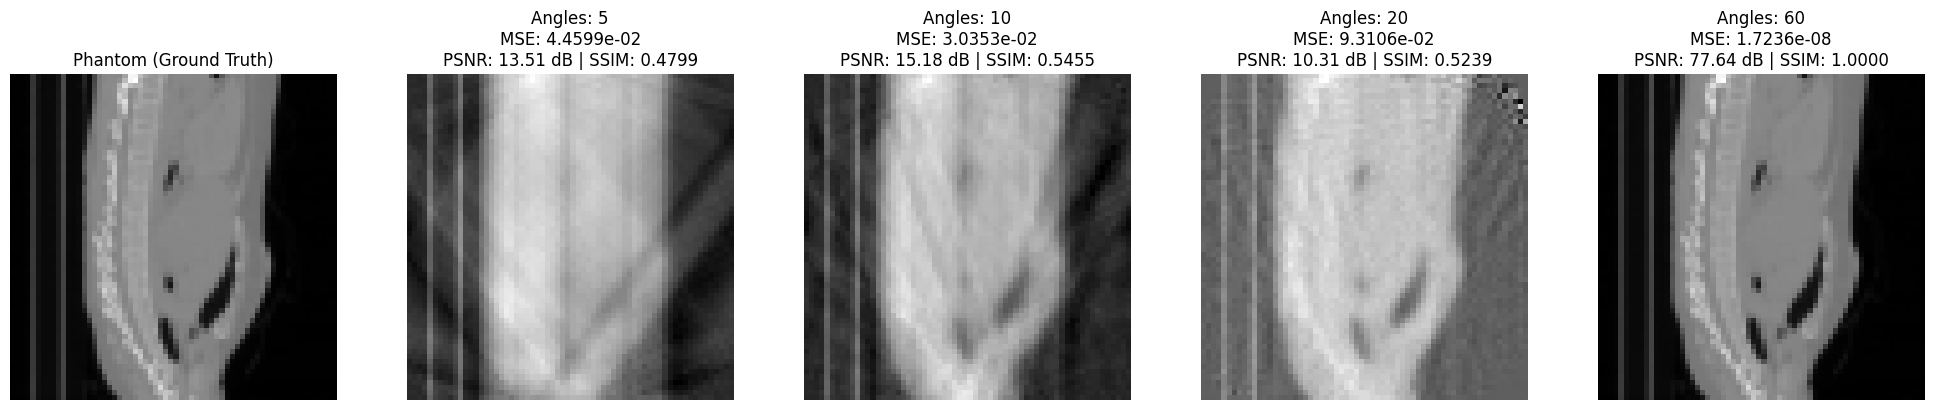

In [15]:
plot_comparison_numpy(reconstructions, phantom_small, num_angles, rows=1)

Se afișează reconstructiile obținute cu metoda SVD; calitatea este ușor mai redusă comparativ cu LSTSQ, dar diferența este mică, iar tendința de îmbunătățire odată cu creșterea numărului de unghiuri se menține.

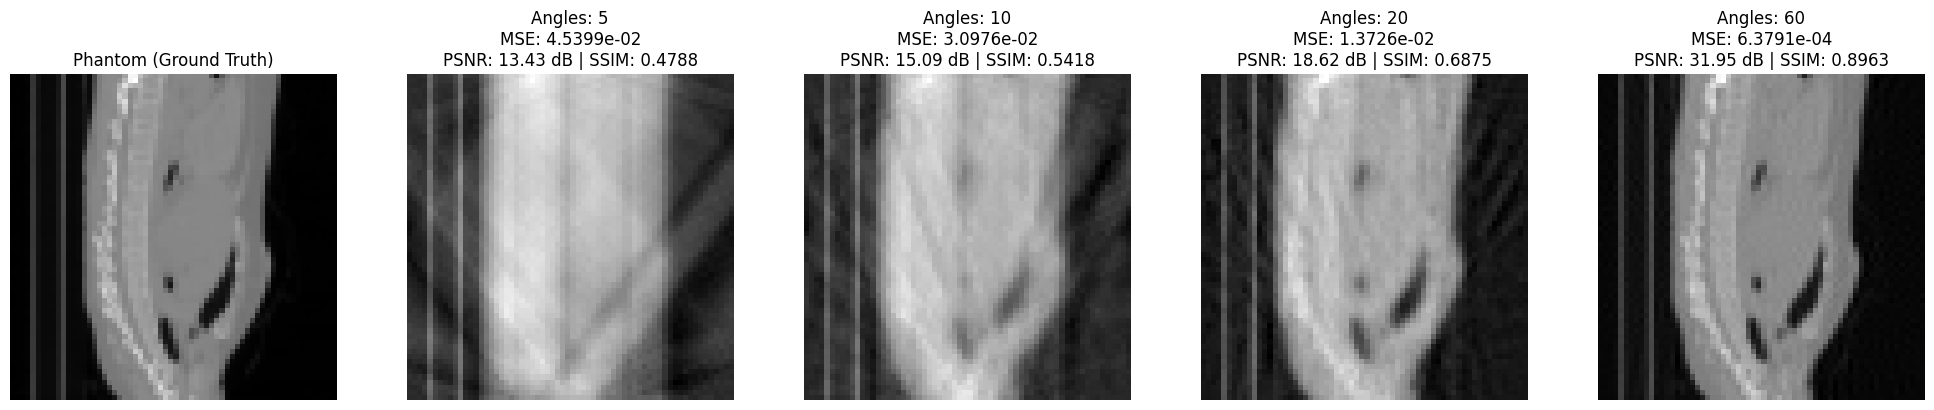

In [16]:
plot_comparison_numpy(reconstructions_svd, phantom_small, num_angles, rows=1)

Se afișează reconstructiile obținute cu metoda Cholesky; calitatea este considerabil mai bună decât SVD, oferind imagini mai apropiate de phantom, mai ales pe măsură ce numărul de unghiuri crește.

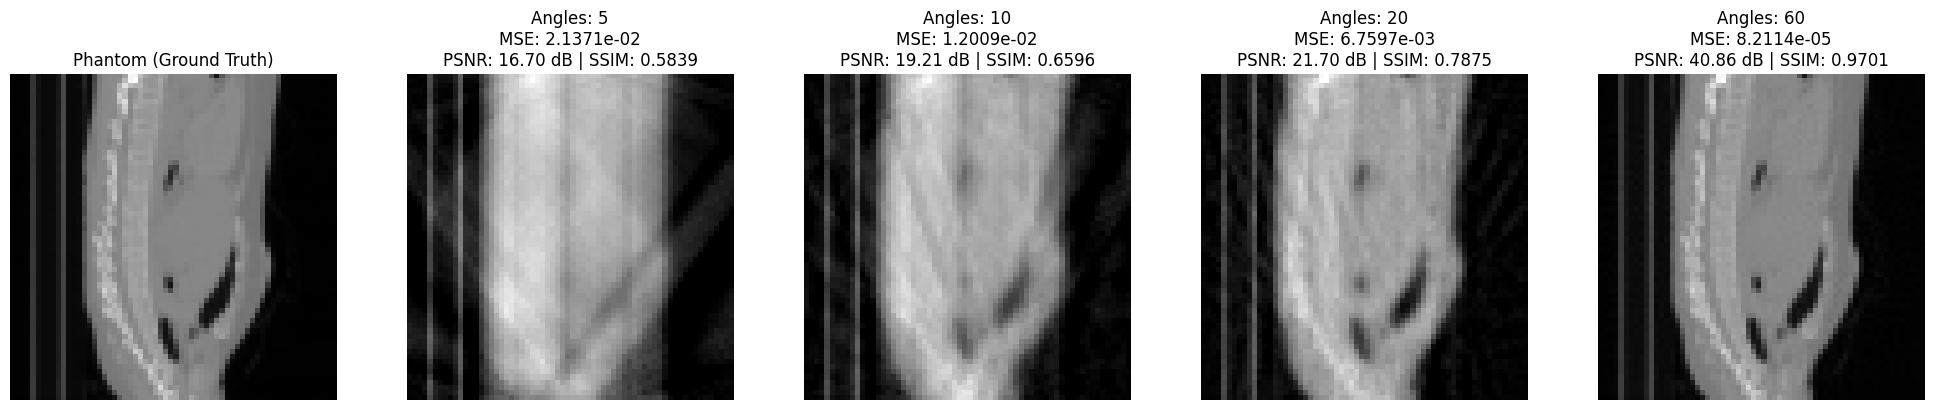

In [17]:
plot_comparison_numpy(reconstructions_cholesky, phantom_small, num_angles, rows=1)

#### Setul de date **Walnut CT**

Se încarcă sinograma și imaginea de referință (ground truth) din setul Walnut.

Se afișează sinograma și se reconstruieste imaginea folosind metoda FBP; imaginea este apoi răsturnată vertical pentru orientarea corectă și comparată vizual și numeric cu ground truth-ul.

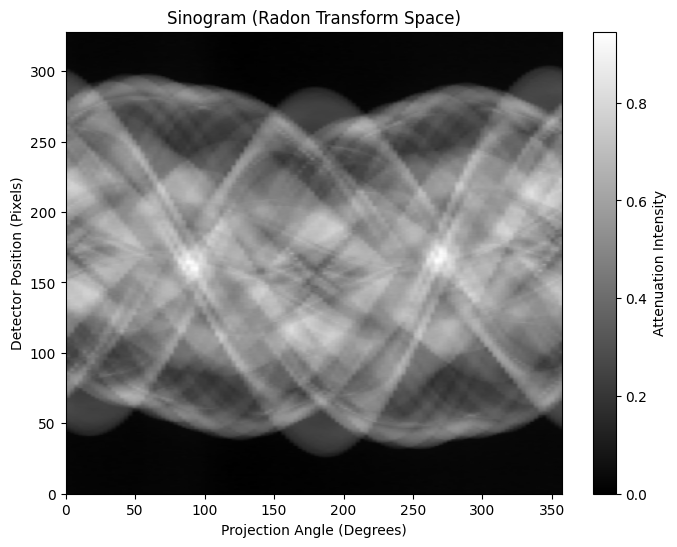

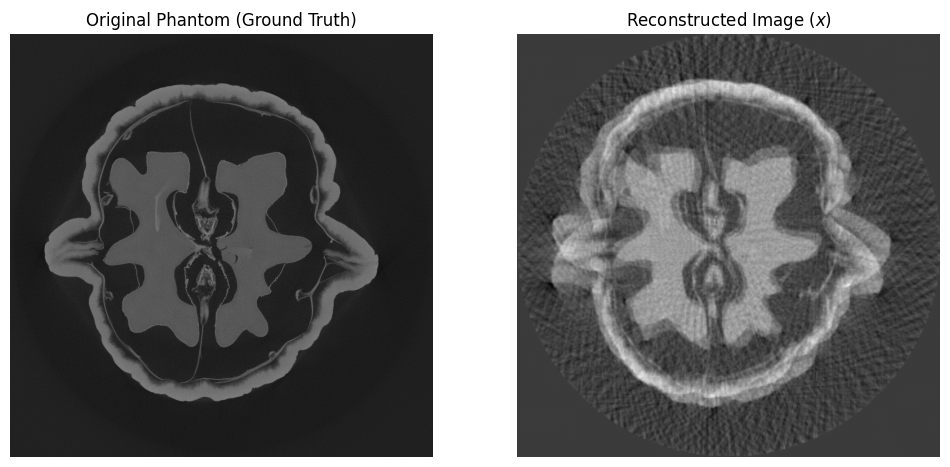

 Reconstruction Quality Metrics:
Mean Squared Error (MSE): 0.034200
PSNR: 14.66 dB
SSIM: 0.5035


In [18]:
# Load Walnut Dataset
sinogram_walnut, gt_walnut = load_walnut_data()

theta_walnut = np.linspace(0., 360., sinogram_walnut.shape[1], endpoint=False)
display_sinogram(sinogram_walnut, theta_walnut)

# Reconstruct using FBP
recon_walnut = reconstruct_image(sinogram_walnut, theta_walnut, circle=True, output_size=328, method='FBP')

# Flip for correct orientation
recon_walnut = np.flipud(recon_walnut)

plot_comparison(recon_walnut, gt_walnut)

Spre deosebire de setul COVID-19, unde datele sunt simulate, setul Walnut conține măsurători reale. Din acest motiv, calitatea reconstructiei poate fi influențată de zgomotul și erorile specifice procesului de achiziție real. Pentru o imagine mai clara, ar fi necesara aplicarea unor tehnici suplimentare de preprocesare a datelor sau de postprocesare a imaginii reconstruite.

De asemenea, se observa ca, in imaginea contruita, exista 2 imagini suprapuse. Acest apare din cauza faptului ca, in viata reala, razele X nu sunt perfect paralele, lucru care ar trebui luat in considerare in modelul matematic pentru a obtine o reconstructie corecta.

#### Algoritmi manuali
Se încarcă o sinogramă cu rezolutie scazuta, pentru a minimiza costul computational.

Se construiește matricea sistemului A pentru rezoluția dorită (n=82).

Sinograma este redimensionată pentru a se potrivi cu numărul de detectoare generate de transformata Radon în matricea A, pregătind datele pentru metodele algebrice de reconstructie.

In [19]:
# Load data
sinogram_walnut, gt_walnut = load_walnut_data(file_name="Data82.mat")
num_detectors_real, num_angles = sinogram_walnut.shape
n = 82 
theta_walnut = np.linspace(0., 360., num_angles, endpoint=False)

# 2. Build A (Resolution n=82)
A = build_system_matrix(n, theta_walnut)

# Determine how many detectors radon() produced for A
expected_detectors = A.shape[0] // num_angles

# Resize the sinogram to match A's expected detector count
sinogram_ready = resize(sinogram_walnut, (expected_detectors, num_angles), anti_aliasing=True)

Constructing A matrix (13920x6724) using Parallel CPU...


Building A:   0%|          | 0/6724 [00:00<?, ?it/s]

In [20]:
# Time the reconstructions
start = time.time()
recon = reconstruct_image(sinogram_ready, theta_walnut, method="LSTSQ", A=A, n=n, lambd=1.2e-1)
lstsq_time = time.time() - start

start = time.time()
recon_svd = reconstruct_image(sinogram_ready, theta_walnut, method="SVD", A=A, n=n, lambd=1.2e-1)
svd_time = time.time() - start

start = time.time()
recon_cholesky = reconstruct_image(sinogram_ready, theta_walnut, method="CHOLESKY", A=A, n=n, lambd=2e2)
cholesky_time = time.time() - start

print(f"LSTSQ Time: {lstsq_time:.4f}s, SVD Time: {svd_time:.4f}s, CHOLESKY Time: {cholesky_time:.4f}s")

# Standardize orientation for the walnut dataset
recon = np.flipud(recon)
recon_svd = np.flipud(recon_svd)
recon_cholesky = np.flipud(recon_cholesky)

Building Normal Equations...
Factorizing...
Solving...
LSTSQ Time: 77.8676s, SVD Time: 127.3798s, CHOLESKY Time: 2.3915s


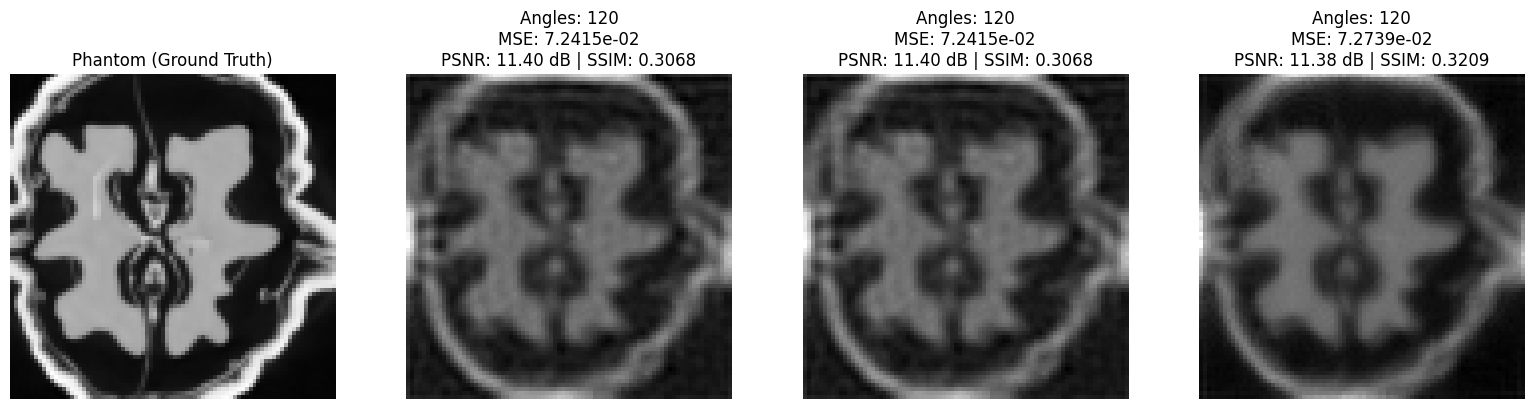

In [21]:
crop_margin = int(0.175 * gt_walnut.shape[0])
gt_walnut_cropped = gt_walnut[
  crop_margin : gt_walnut.shape[0] - crop_margin,
  crop_margin : gt_walnut.shape[1] - crop_margin
]

gt_walnut_small = resize(gt_walnut_cropped, (n, n), anti_aliasing=True)

plot_comparison_numpy([recon, recon_svd, recon_cholesky], gt_walnut_small, [num_angles, num_angles, num_angles])

Se testează metodele LSTSQ, SVD și Cholesky pe sinograma redimensionată, măsurând timpul de execuție pentru fiecare.

Se observă că metoda Cholesky, datorită implementării optimizate din NumPy, rulează semnificativ mai rapid decât celelalte două metode algebrice, apropiindu-se de timpul metodei FBP.

Toate metodele oferă rezultate vizuale comparabile, dar Cholesky pare să ofere un echilibru mai bun între calitate și timp de execuție.

# 6. Bibliografie

 * InRad (Institute of Radiology, University of São Paulo). (n.d.). InRad COVID‑19 X‑Ray and CT scans dataset (Creative Commons Attribution 4.0). Retrieved from https://registry.opendata.aws/inlab-covid-19-images-dataset
 * Hämäläinen, K., Harhanen, L., Kallonen, A., Kujanpää, A., Niemi, E., & Siltanen, S. (2015). Tomographic X‑ray data of a walnut (Version 1.0.0) [Dataset]. Zenodo. https://doi.org/10.5281/zenodo.1254206